In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm

plt.style.use("ggplot")
pyro.set_rng_seed(1209)
np.random.seed(1209)
figsize = (7, 5)


# ToDo

* check Oswin notes for neg_log_likelihood

* Check if loss calculation is the same as getting mu and cov from model.

In [2]:
def g(x):
    return -(torch.sin(6 * torch.pi * x) ** 2) + 6 * x**2 - 5 * x**4 + 3 / 2


In [3]:
def neg_log_likelihood(x, y, GP):
    kernel = GP.kernel
    noise_y = GP.noise
    n_samples = len(x)
    K = kernel.forward(x)

    # ToDo mention that we are using the Cholesky decomposition
    # for the numerical stability of the computation
    # and for performance reasons
    # also add reference to the book

    # Compute the Cholesky decomposition
    upper = False
    L = torch.linalg.cholesky(K + noise_y * torch.eye(n_samples), upper=upper)

    alpha = torch.cholesky_solve(y.reshape(-1, 1), L, upper=upper)
    alpha = alpha.squeeze()
    # L being a diagonal matrix has the determinant equal to the sum of the log of
    # the element on the diagonal
    log_det = torch.sum(torch.log(torch.diag(L)))

    # Negative log-likelihood
    NLL = -0.5 * (
        torch.dot(y.T, alpha)
        + log_det
        + n_samples * torch.log(torch.tensor(2.0) * torch.pi)
    )

    return NLL

In [4]:
def neg_likelihood_prior_joint(x, y, GP, priors):
    params = [
        GP.noise,
        kernel.kern0.lengthscale,
        kernel.kern0.variance,
        kernel.kern1.variance,
        kernel.kern1.period,
        kernel.kern1.lengthscale,
    ]

    neg_likelihood = neg_log_likelihood(x, y, GP)
    log_prob_prior = torch.tensor(0.0)
    for distribution, value in zip(priors, params):
        log_prob_prior += distribution.log_prob(value)

    return neg_likelihood - log_prob_prior


## Plot of generating function $g$

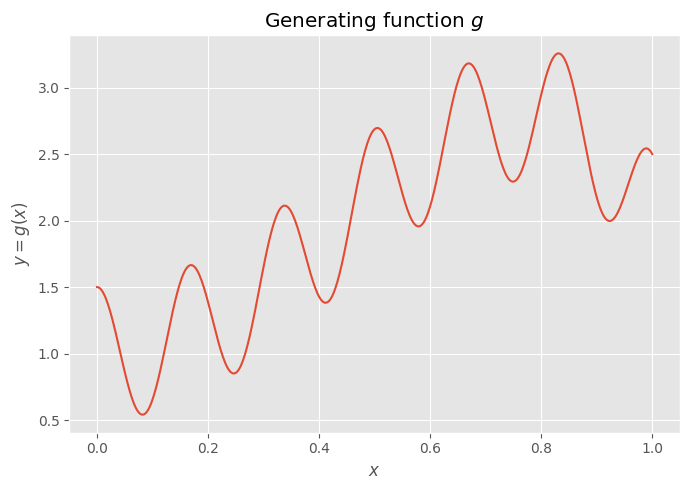

In [5]:
n_points = 500
xs = torch.linspace(0.0, 1.0, n_points)
ys = g(xs)

fig, ax = plt.subplots(figsize=figsize)
ax.plot(xs, ys)
ax.set_title(r"Generating function $g$")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y=g(x)$")
plt.tight_layout()
plt.show()


# Training and test data

We assume observations are given by:

$$
y_i = g(x_i) + \epsilon_i, \quad 
$$

where the observations are the grid $x_i = \frac{i-1}{l-1}, i=1,\ldots,l$ with $l=30$.

In [6]:
def generate_data(l=30, split=1.0 / 3.0):
    """
    Generate training and test data for the function g(x) = -(sin(6*pi*x)^2) + 6x^2 - 5x^4 + 3/2.
    :param l: Number of data points.
    :param split: Fraction of data to use as test data.
    :return: x_train, y_train, x_test, y_test
    """
    x = (torch.arange(1, l + 1) - 1) / (l - 1)
    y = g(x) + torch.sqrt(torch.tensor(0.01)) * torch.randn(len(x))

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=split, random_state=3317
    )

    return x_train, y_train, x_test, y_test

In [7]:
x_train, y_train, x_test, y_test = generate_data()

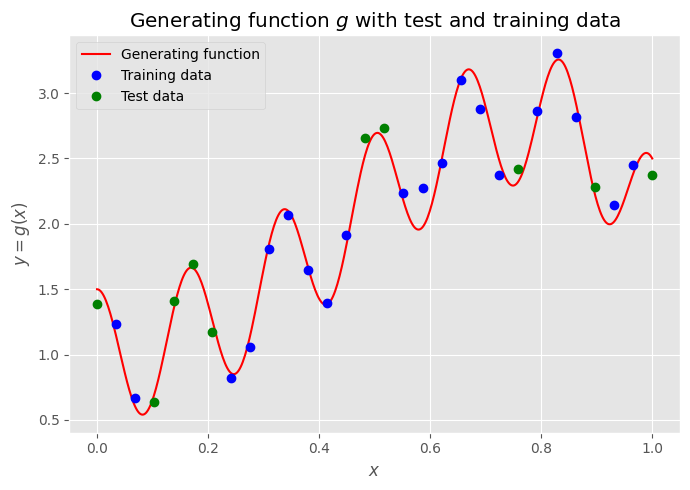

In [8]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(xs, ys, label="Generating function", color="red")
ax.plot(x_train, y_train, "o", label="Training data", color="blue")
ax.plot(x_test, y_test, "o", label="Test data", color="green")
ax.set_title(r"Generating function $g$ with test and training data")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y=g(x)$")
ax.legend()
plt.tight_layout()
plt.show()


## Setup Gaussian kernel

In [9]:
# Choice of kernel:
# Data is periodic, so we use a periodic kernel
# Data is increasing, so we use a linear kernel
# Sum of kernels is also a kernel
# We use a sum of a linear and a periodic kernel
# The periodic kernel is due to David Mackey: Introduction to Gaussian Processes, eq. 47
# Kernel cookbook: https://www.cs.toronto.edu/~duvenaud/cookbook/

# the linear kernel alone is equivalent to a linear regression

# refer to the "the kernel cookbook" for more information on kernels

# play around with the hyperparameters to see how they affect the model

linear = gp.kernels.Linear(input_dim=1, variance=torch.tensor(2.0))


rbf = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(1.0)
)

periodic = gp.kernels.Periodic(
    input_dim=1,
    period=torch.tensor(1 / 3),
    lengthscale=torch.tensor(1.0),
    variance=torch.tensor(1.0),
)

kernel = gp.kernels.Product(kern0=rbf, kern1=periodic)


## Perform GP regression with chosen kernel

Note this is done for a fixed set of kernel parameters.

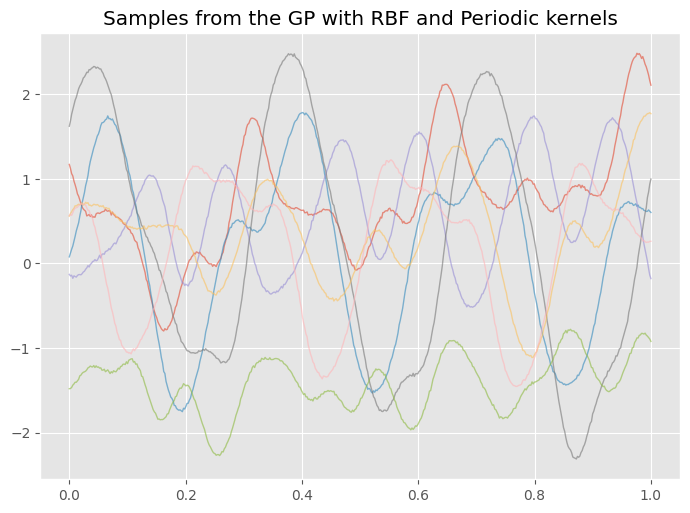

In [10]:
gpr = gp.models.GPRegression(x_train, y_train, kernel=kernel, noise=torch.tensor(0.01))

# Samples from the GP
n_samples = 7

cov = kernel.forward(xs)
samples = dist.MultivariateNormal(
    torch.zeros(n_points),
    covariance_matrix=cov
    + torch.diag(torch.ones(n_points) * 0.0001),  ## ToDo should noise be added here?
).sample(sample_shape=(n_samples,))

fig, ax = plt.subplots(figsize=figsize)

for sample in samples:
    ax.plot(xs, sample, lw=1, alpha=0.6)

plt.tight_layout()
plt.title("Samples from the GP with RBF and Periodic kernels")
plt.show()


## Plot GP regression (no tuning of hyperparameters)

This is just a sanity check to see if model is capable of matching data

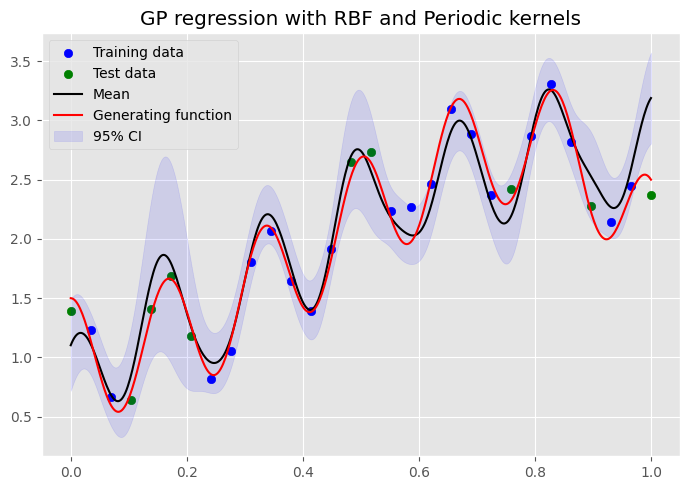

In [11]:
with torch.no_grad():
    mean, cov = gpr(xs, noiseless=False)

fig, ax = plt.subplots(figsize=figsize)
ax.scatter(x_train, y_train, label="Training data", color="blue")
ax.scatter(x_test, y_test, label="Test data", color="green")
ax.plot(xs, mean, label="Mean", color="black")
ax.plot(xs, ys, label="Generating function", color="red")
ax.fill_between(
    xs,
    mean + torch.sqrt(cov) * 1.95996,
    mean - torch.sqrt(cov) * 1.95996,
    color="blue",
    alpha=0.1,
    label="95% CI",
)
ax.set_title("GP regression with RBF and Periodic kernels")
ax.legend()
plt.tight_layout()
plt.show()

## Use gradient descent to find optimal hyperparameters $\theta$

In [ ]:
losses_list = []
neg_likelihood_prior_joints_list = []
test_loglikelihoods = []
gaussian_processes = []

generated_data_list = []

smoke_test = False
iterations = 20 if not smoke_test else 5

for i in range(iterations):
    print(f"Iteration {i + 1}/{iterations}")
    pyro.clear_param_store()
    x_train, y_train, x_test, y_test = generate_data()
    generated_data_list.append((x_train, y_train, x_test, y_test))

    # Defining our kernels and GP-model
    linear = gp.kernels.Linear(input_dim=1, variance=torch.tensor(2.0))

    rbf = gp.kernels.RBF(
        input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(0.9)
    )
    periodic = gp.kernels.Periodic(
        input_dim=1,
        period=torch.tensor(1 / 3),
        lengthscale=torch.tensor(1.0),
        variance=torch.tensor(1.0),
    )
    kernel = gp.kernels.Product(kern0=rbf, kern1=periodic)
    # kernel = periodic
    gpr = gp.models.GPRegression(
        x_train, y_train, kernel=kernel, noise=torch.tensor(0.01)
    )

    # Putting priors on our kernel parameters
    gpr.kernel.kern0.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    gpr.kernel.kern0.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 1.0))
    gpr.kernel.kern1.period = pyro.nn.PyroSample(
        dist.LogNormal(torch.log(torch.tensor(1 / 3)), 0.1**2)
    )
    gpr.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    gpr.kernel.kern1.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 1.0))
    gpr.noise = pyro.nn.PyroSample(dist.Gamma(1.0, 1.0))

    priors = [  # disse kan defineres udenfor loop
        dist.Gamma(1, 1),
        dist.LogNormal(0, 1),
        dist.LogNormal(1, 1),
        dist.LogNormal(1, 1),
        dist.LogNormal(torch.log(torch.tensor(1 / 3)), 0.1**2),
        dist.LogNormal(0, 1),
    ]

    # SVI with delta distribution as guide
    optimizer = torch.optim.Adam(gpr.parameters(), lr=0.001)
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss  # ToDO er der andre loss fns
    losses = []
    neg_likelihood_prior_joints = []
    num_steps = 3000
    for i in tqdm(range(num_steps)):
        gpr.set_mode("model")
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        gpr.set_mode("guide")
        neg_likelihood_prior_joints.append(
            neg_likelihood_prior_joint(x_train, y_train, gpr, priors).detach().numpy()
        )

    gpr.set_mode("guide")

    losses_list.append(losses)
    neg_likelihood_prior_joints_list.append(neg_likelihood_prior_joints)
    test_loglikelihoods.append(neg_log_likelihood(x_test, y_test, gpr))

    gaussian_processes.append(gpr)


Iteration 1/20


  0%|          | 0/3000 [00:00<?, ?it/s]/var/folders/fy/zx0sb02j5rv66mcpx65ldmvc0000gn/T/ipykernel_92637/4064280118.py:24: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3687.)
  torch.dot(y.T, alpha)
100%|██████████| 3000/3000 [00:07<00:00, 426.42it/s]


Iteration 2/20


100%|██████████| 3000/3000 [00:07<00:00, 424.17it/s]


Iteration 3/20


100%|██████████| 3000/3000 [00:07<00:00, 428.04it/s]


Iteration 4/20


100%|██████████| 3000/3000 [00:06<00:00, 441.25it/s]


Iteration 5/20


100%|██████████| 3000/3000 [00:06<00:00, 446.59it/s]


Iteration 6/20


100%|██████████| 3000/3000 [00:06<00:00, 438.39it/s]


Iteration 7/20


100%|██████████| 3000/3000 [00:06<00:00, 439.06it/s]


Iteration 8/20


100%|██████████| 3000/3000 [00:06<00:00, 437.13it/s]


Iteration 9/20


100%|██████████| 3000/3000 [00:06<00:00, 442.42it/s]


Iteration 10/20


100%|██████████| 3000/3000 [00:06<00:00, 432.96it/s]


Iteration 11/20


100%|██████████| 3000/3000 [00:07<00:00, 426.80it/s]


Iteration 12/20


100%|██████████| 3000/3000 [00:07<00:00, 415.67it/s]


Iteration 13/20


100%|██████████| 3000/3000 [00:06<00:00, 439.40it/s]


Iteration 14/20


100%|██████████| 3000/3000 [00:06<00:00, 443.16it/s]


Iteration 15/20


100%|██████████| 3000/3000 [00:06<00:00, 445.81it/s]


Iteration 16/20


100%|██████████| 3000/3000 [00:06<00:00, 433.06it/s]


Iteration 17/20


100%|██████████| 3000/3000 [00:07<00:00, 427.02it/s]


Iteration 18/20


100%|██████████| 3000/3000 [00:06<00:00, 428.64it/s]


Iteration 19/20


100%|██████████| 3000/3000 [00:06<00:00, 444.65it/s]


Iteration 20/20


100%|██████████| 3000/3000 [00:06<00:00, 445.65it/s]


In [13]:
map_test_log_likelihood = [x.detach().item() for x in test_loglikelihoods]
map_test_log_likelihood


[-12.845663070678711,
 -11.92534065246582,
 -12.938199996948242,
 -13.013025283813477,
 -12.58405876159668,
 -14.971349716186523,
 -12.813676834106445,
 -12.296675682067871,
 -12.014432907104492,
 -12.408483505249023,
 -12.0713529586792,
 -12.794227600097656,
 -12.345871925354004,
 -12.234722137451172,
 -11.607013702392578,
 -12.453836441040039,
 -12.268890380859375,
 -12.202347755432129,
 -12.940900802612305,
 -11.98383903503418]

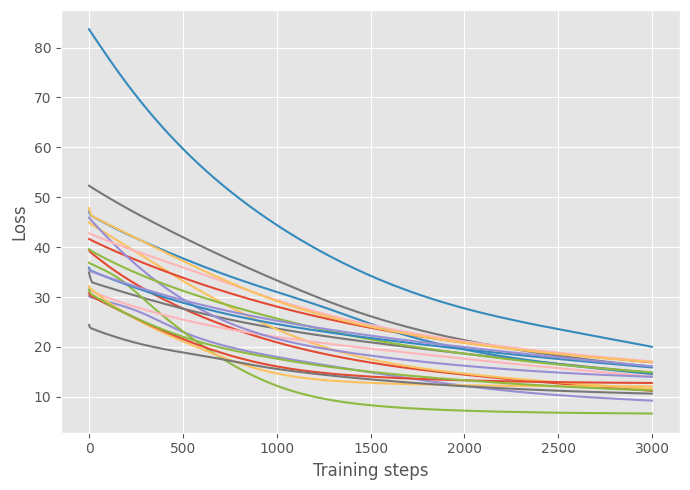

In [14]:
fig, ax = plt.subplots(figsize=figsize)

ax.set_xlabel("Training steps")
ax.set_ylabel("Loss")
for l in losses_list:
    ax.plot(l)

plt.tight_layout()
plt.show()


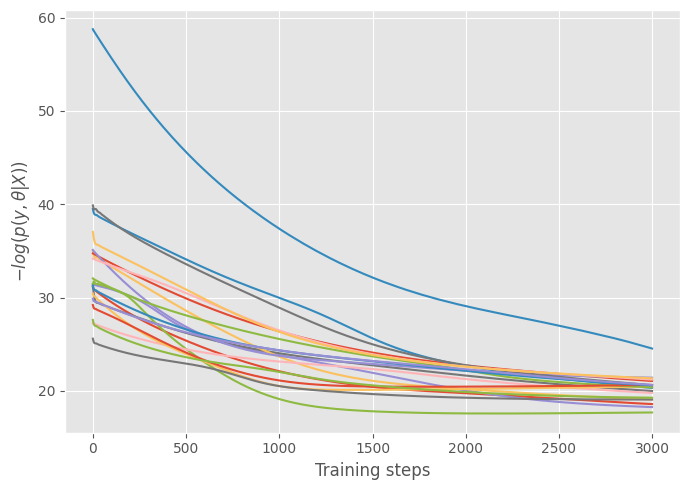

In [15]:
fig, ax = plt.subplots(figsize=figsize)

ax.set_xlabel("Training steps")
ax.set_ylabel(r"$-log(p(y, \theta | X))$")
for l in neg_likelihood_prior_joints_list:
    ax.plot(l)

plt.tight_layout()
plt.show()


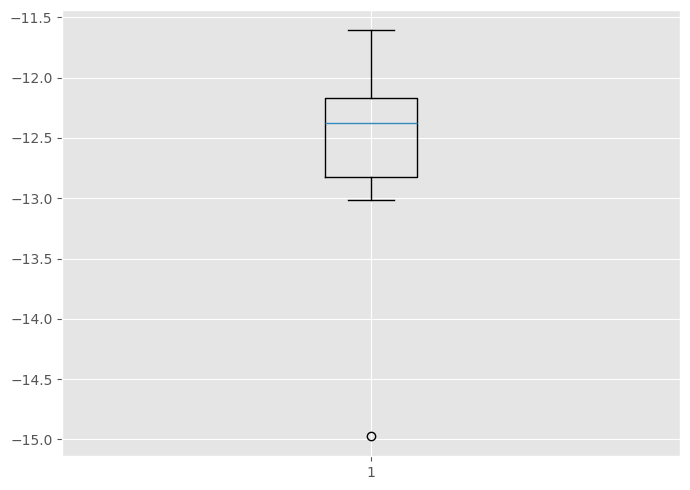

In [16]:
[x.detach().item() for x in test_loglikelihoods]

fig, ax = plt.subplots(figsize=figsize)

ax.boxplot([x.detach().item() for x in test_loglikelihoods])
plt.tight_layout()
plt.show()


# Måske histogrammer af MAPs

In [17]:
def plotfct(generated_data_list, xs, ys, mean, cov, i):
    fig, ax = plt.subplots(figsize=figsize)

    ax.scatter(
        generated_data_list[i][0],
        generated_data_list[i][1],
        color="blue",
        label="Train data",
    )  # plot train data
    ax.scatter(
        generated_data_list[i][2],
        generated_data_list[i][3],
        color="red",
        label="Test data",
    )  # plot test data
    ax.plot(xs, mean, color="blue", label="Prediction mean")  # plot mean
    ax.plot(xs, ys, color="orange", label=r"$g(x)$")  # plot g(x)
    ax.fill_between(
        xs,
        mean + torch.sqrt(cov) * 1.95,
        mean - torch.sqrt(cov) * 1.95,
        color="blue",
        alpha=0.1,
        label="Prediction variance",
    )  # plot var
    ax.set_title(
        f"GP regression with sum of RBF and Periodic kernels - iteration {i+1}"
    )
    ax.legend()

    plt.tight_layout()
    plt.savefig(f"./figures/gp_{i+1}.png")
    plt.show()

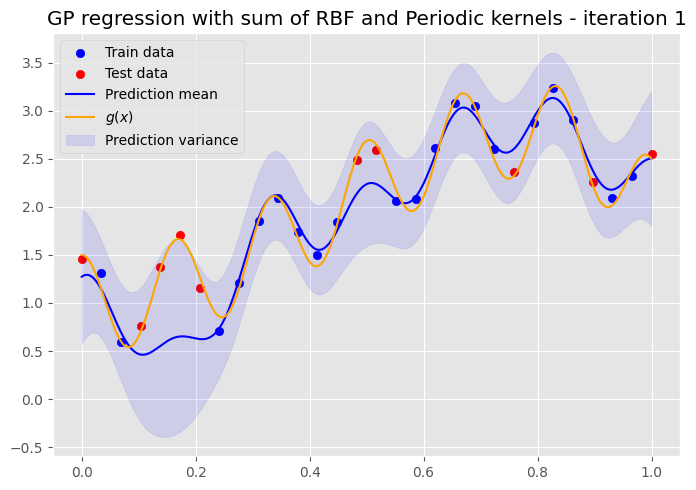

RBF length 0.5082088112831116 var 1.1636264324188232
PERIODIC per 0.3333839476108551 length 1.9306272268295288 var 1.6729626655578613


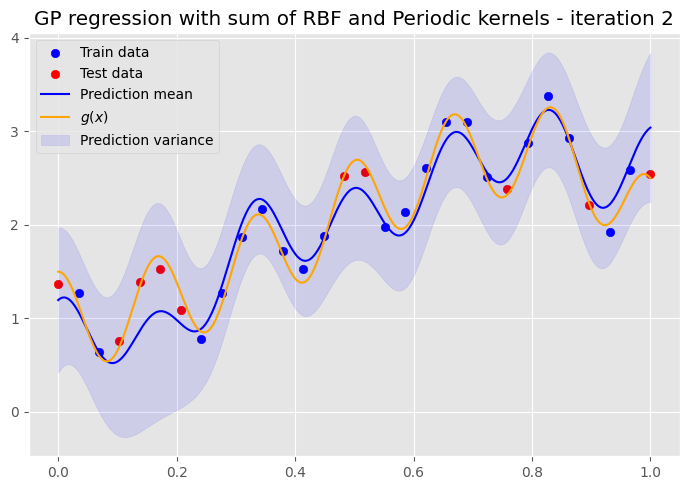

RBF length 1.1560903787612915 var 8.83283519744873
PERIODIC per 0.33310967683792114 length 3.0610287189483643 var 2.1713569164276123


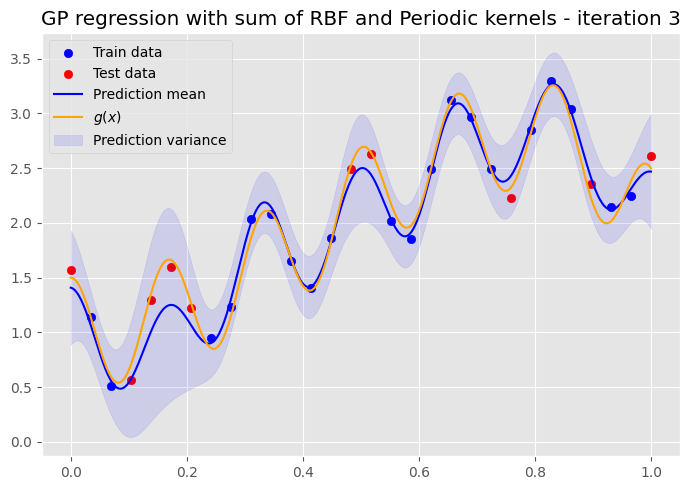

RBF length 0.5242722034454346 var 1.4186315536499023
PERIODIC per 0.33371883630752563 length 1.753474473953247 var 1.4234169721603394


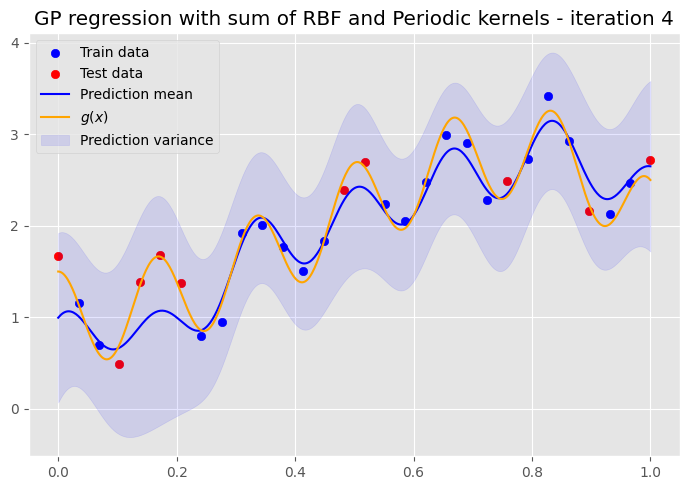

RBF length 0.6245243549346924 var 1.391725778579712
PERIODIC per 0.3330692648887634 length 1.7477266788482666 var 1.3963510990142822


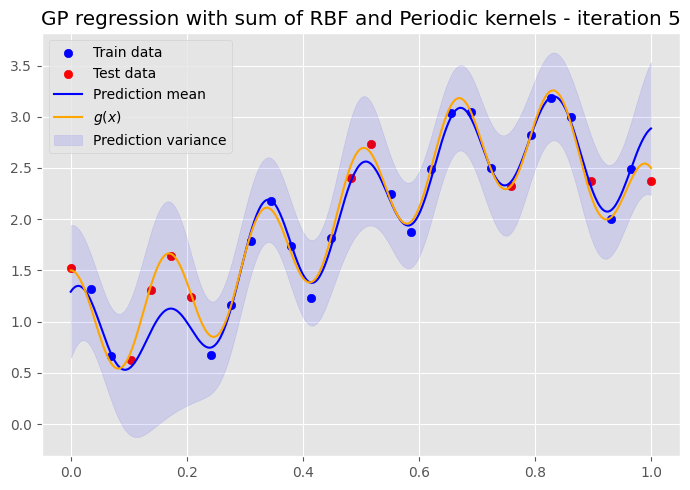

RBF length 0.577064573764801 var 2.0449278354644775
PERIODIC per 0.3333628475666046 length 1.6698542833328247 var 1.028328537940979


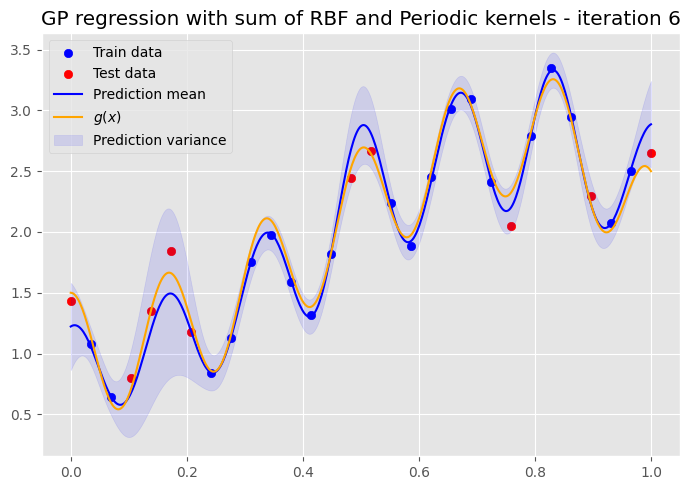

RBF length 0.5491964817047119 var 1.4242961406707764
PERIODIC per 0.33380794525146484 length 1.7606481313705444 var 1.5212018489837646


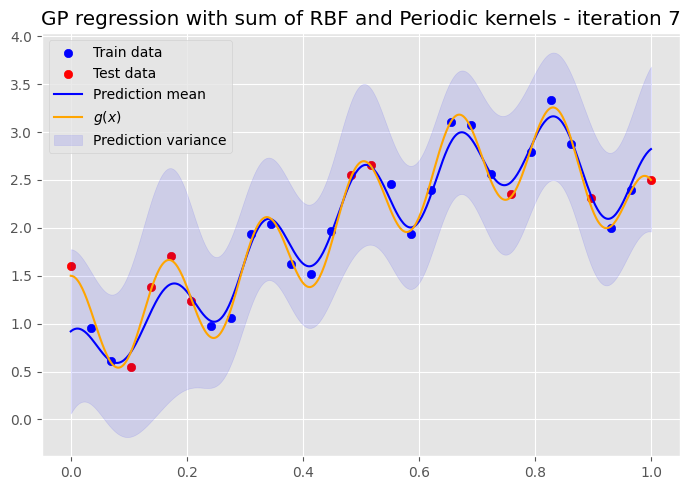

RBF length 0.6221085786819458 var 1.4088321924209595
PERIODIC per 0.3334490656852722 length 1.685093879699707 var 1.4104161262512207


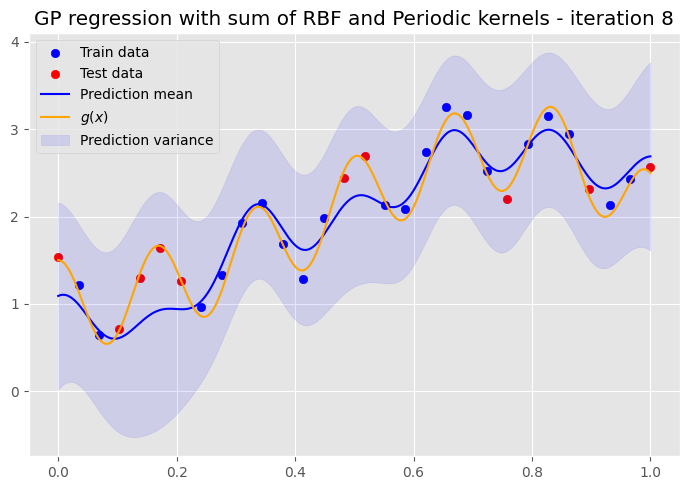

RBF length 0.5619611740112305 var 1.3040655851364136
PERIODIC per 0.33334434032440186 length 1.8577423095703125 var 1.4534966945648193


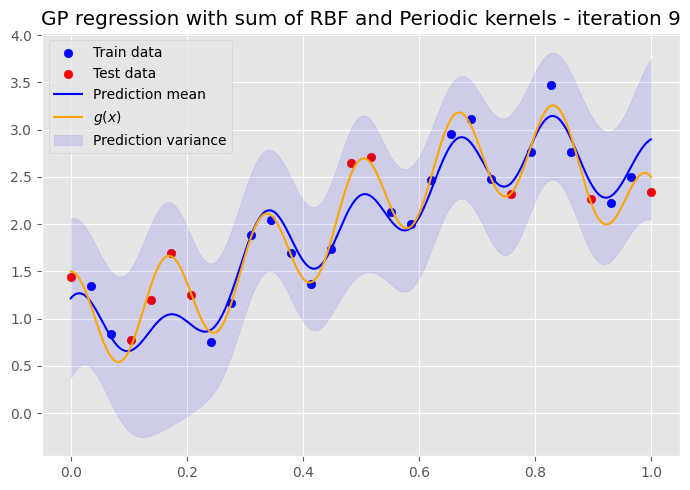

RBF length 0.6778290867805481 var 1.791454792022705
PERIODIC per 0.333110511302948 length 1.8004757165908813 var 1.2481580972671509


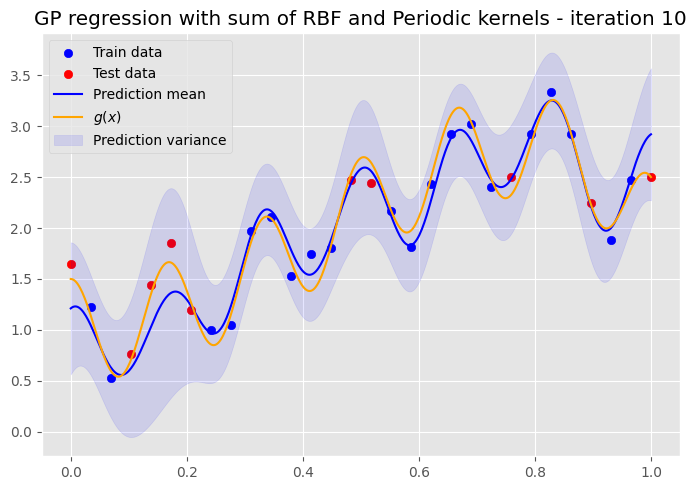

RBF length 0.7149311900138855 var 4.190012454986572
PERIODIC per 0.33303186297416687 length 1.7294788360595703 var 0.5892138481140137


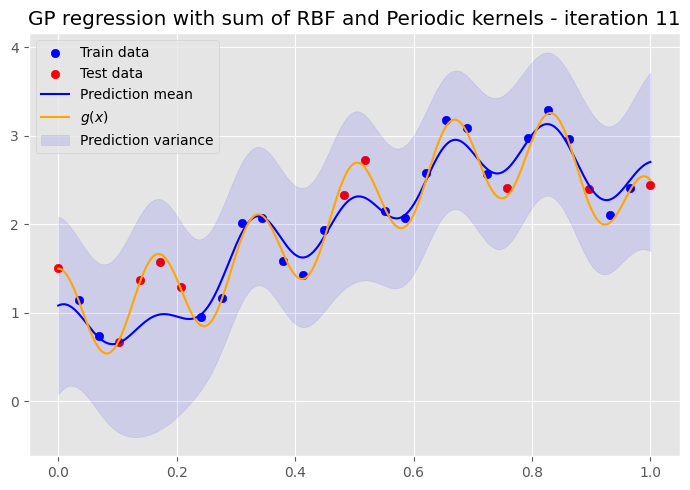

RBF length 0.5675079226493835 var 2.2461750507354736
PERIODIC per 0.33335721492767334 length 1.8523634672164917 var 0.8897523283958435


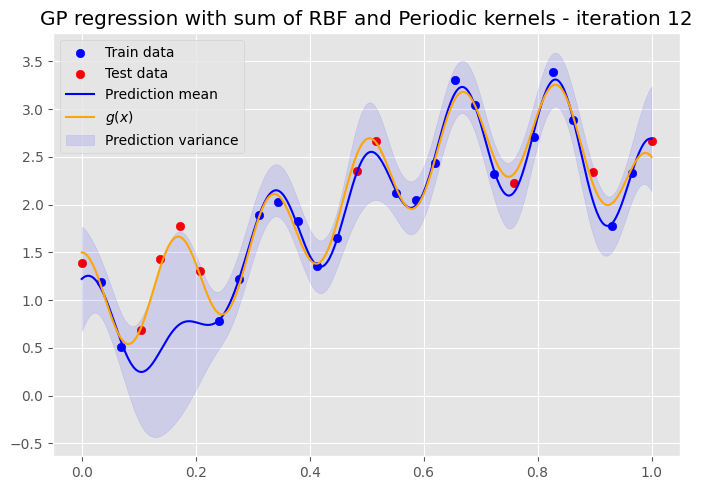

RBF length 0.509161114692688 var 1.471496820449829
PERIODIC per 0.333584189414978 length 1.6092147827148438 var 1.4358317852020264


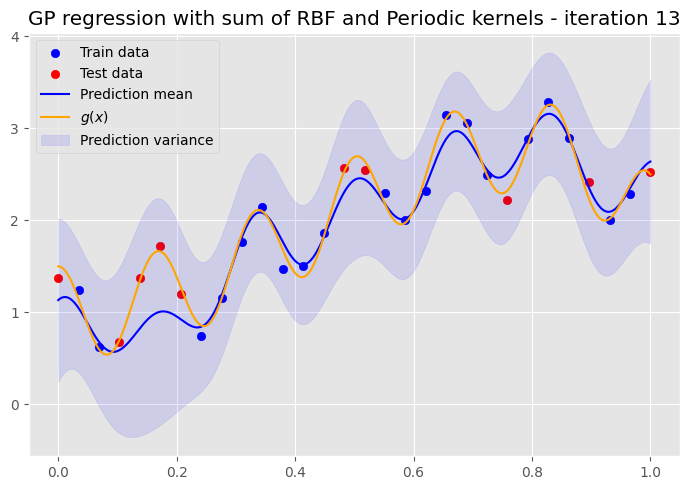

RBF length 0.5441241264343262 var 1.3018954992294312
PERIODIC per 0.33334267139434814 length 1.7176295518875122 var 1.4901412725448608


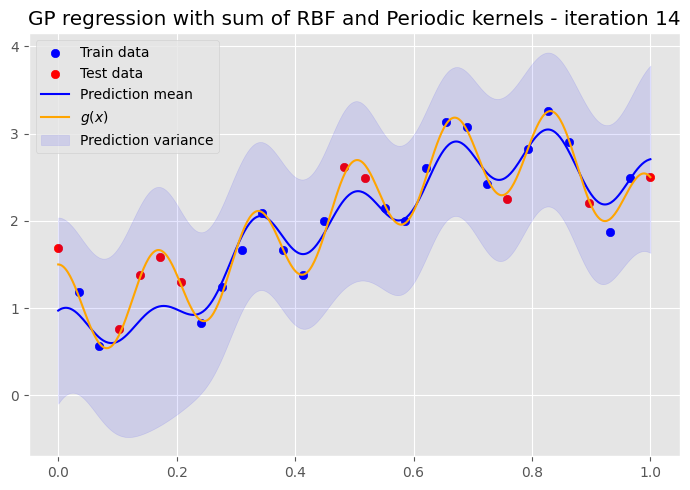

RBF length 0.5884921550750732 var 1.387500524520874
PERIODIC per 0.3332628011703491 length 1.7933790683746338 var 1.3926395177841187


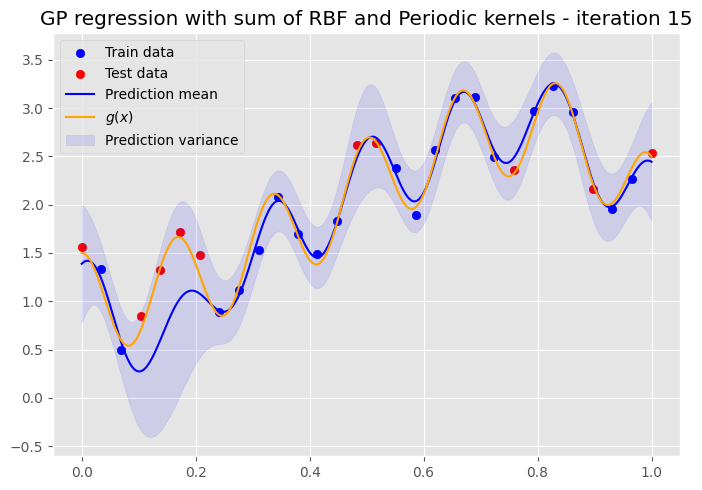

RBF length 0.4560549259185791 var 1.4280242919921875
PERIODIC per 0.33299362659454346 length 1.6905431747436523 var 1.429643154144287


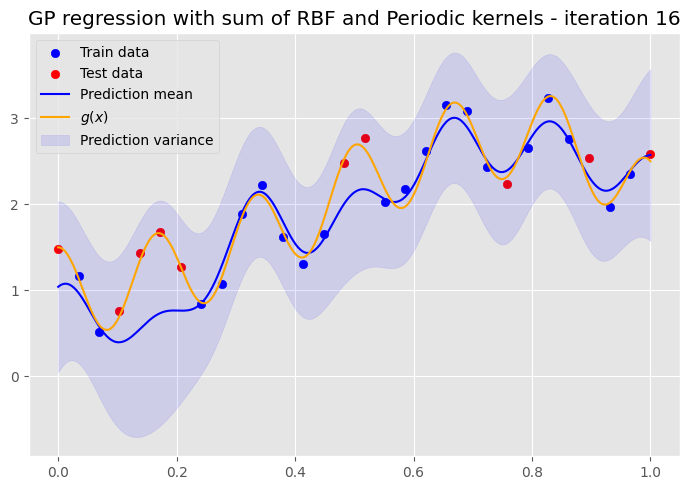

RBF length 0.5366230607032776 var 1.4388374090194702
PERIODIC per 0.33316290378570557 length 1.7579474449157715 var 1.3060331344604492


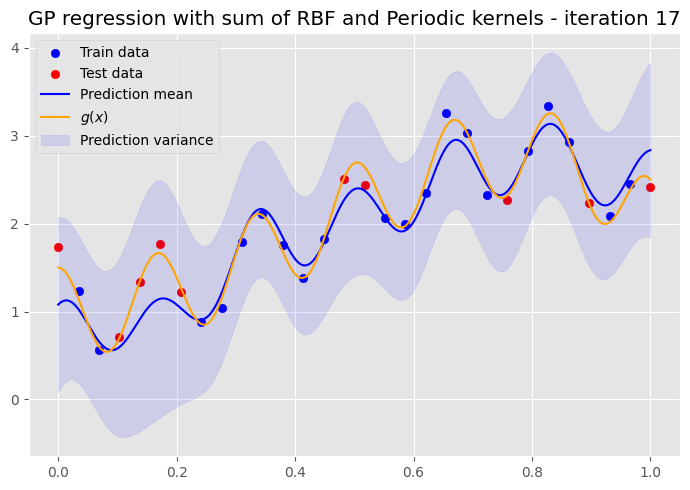

RBF length 0.6528127193450928 var 1.42887544631958
PERIODIC per 0.333094984292984 length 1.6563481092453003 var 1.4299565553665161


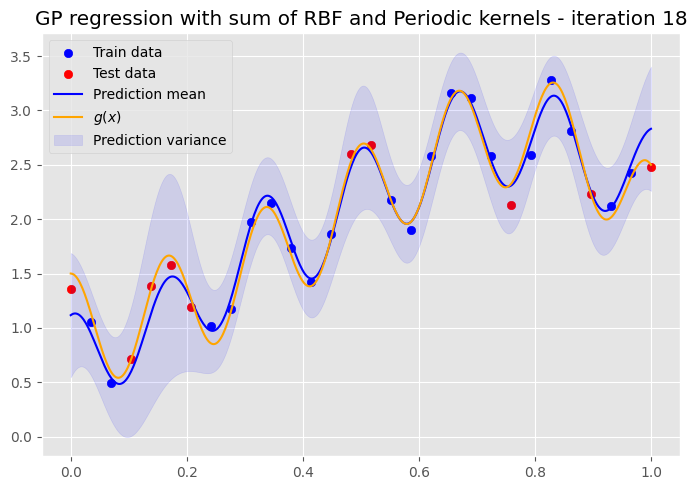

RBF length 0.5932886600494385 var 1.363918423652649
PERIODIC per 0.33358991146087646 length 1.680273175239563 var 1.4429116249084473


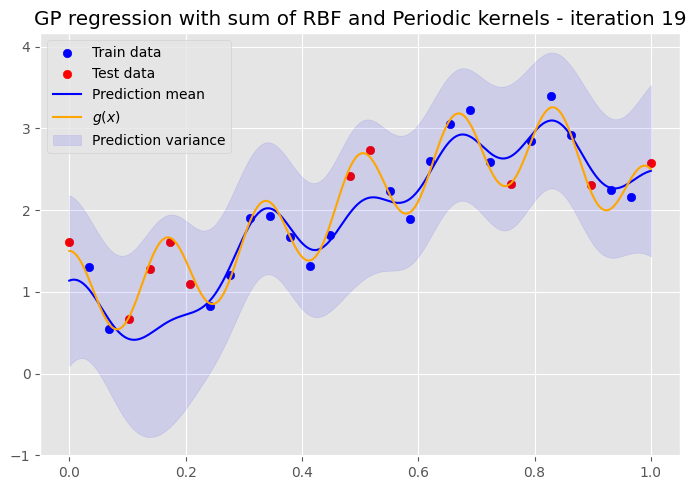

RBF length 0.4980621039867401 var 1.3994876146316528
PERIODIC per 0.33333268761634827 length 1.961657166481018 var 1.361127495765686


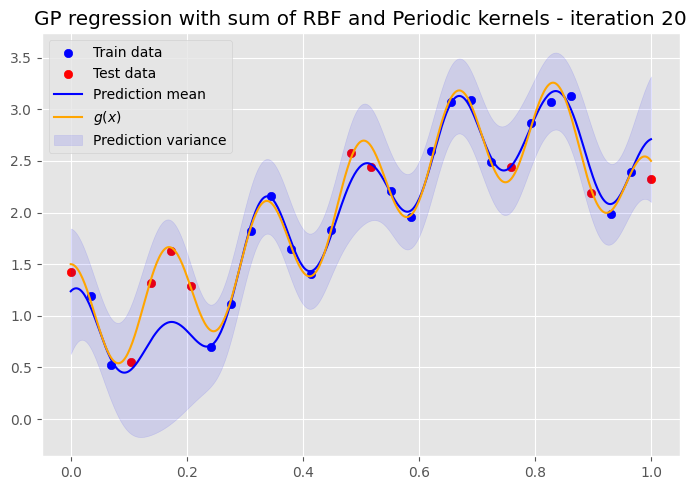

RBF length 0.5385114550590515 var 1.8340121507644653
PERIODIC per 0.3335215747356415 length 1.6981124877929688 var 1.1114602088928223


In [18]:
for i, gp in enumerate(gaussian_processes):
    pyro.clear_param_store()
    gp.set_mode("guide")
    with torch.no_grad():
        mean, cov = gp(xs, noiseless=False)

    plotfct(generated_data_list, xs, ys, mean, cov, i)

    print(
        f"RBF length {gp.kernel.kern0.lengthscale} var {gp.kernel.kern0.variance}\n"
        f"PERIODIC per {gp.kernel.kern1.period} length {gp.kernel.kern1.lengthscale} var {gp.kernel.kern1.variance}"
    )